<a href="https://colab.research.google.com/github/prachiisalunkhe/-Tree_species_detection/blob/main/_TreeSpecies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
image_dir = '/content/drive/MyDrive/datasets/Tree_Species_Dataset'


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_path = '/content/drive/MyDrive/datasets/Tree_Species_Dataset'

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 1179 images belonging to 31 classes.
Found 285 images belonging to 31 classes.


In [8]:
import os

repo_path = "/content/drive/MyDrive/datasets/Tree_Species_Dataset"  # Adjust if cloned to a different name
print("Contents:", os.listdir(repo_path))


Contents: ['sugarcane', 'other', 'saptaparni', 'sonmahor', 'sitafal', 'pilikaren', 'simlo', 'pipal', 'shirish', 'vad', 'kanchan', 'mango', 'khajur', 'nilgiri', 'kesudo', 'gunda', 'neem', 'motichanoti', 'gulmohor', 'jamun', 'coconut', 'cactus', 'champa', 'bili', 'babul', 'garmalo', 'banyan', 'bamboo', 'asopalav', 'amla', '.git']


In [9]:
class_dirs = os.listdir(repo_path)
print(f"Number of classes: {len(class_dirs)}")


Number of classes: 31


In [10]:
import glob

image_paths = []
labels = []

for class_name in os.listdir(repo_path):
    class_folder = os.path.join(repo_path, class_name)
    if os.path.isdir(class_folder):
        for img_file in os.listdir(class_folder):
            image_paths.append(os.path.join(class_folder, img_file))
            labels.append(class_name)

print(f"Total images: {len(image_paths)}")


Total images: 1469


In [11]:
import pandas as pd

class_counts = {cls: len(os.listdir(os.path.join(repo_path, cls))) for cls in class_dirs}
class_counts_df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Image Count'])
print(class_counts_df.sort_values('Image Count', ascending=False).head())
print("shape: ",class_counts_df.shape)


            Image Count
other                74
sugarcane            50
saptaparni           50
sonmahor             50
sitafal              50
shape:  (31, 1)


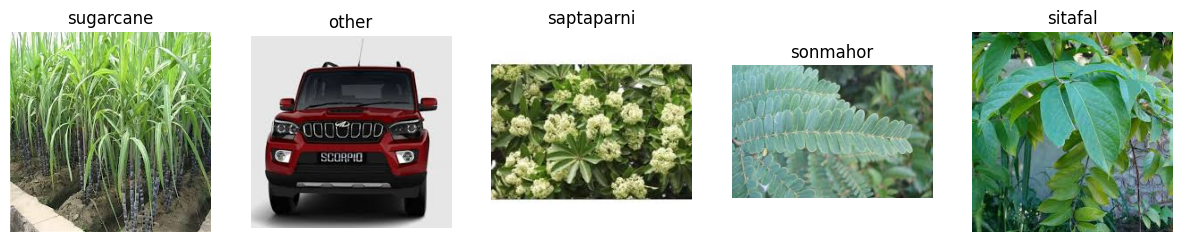

In [12]:
import matplotlib.pyplot as plt
from PIL import Image

def show_sample_images(repo_path, class_dirs, n=5):
    plt.figure(figsize=(15, 10))
    for i, class_dir in enumerate(class_dirs[:n]):
        img_path = os.path.join(repo_path, class_dir, os.listdir(os.path.join(repo_path, class_dir))[0])
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(class_dir)
        plt.axis('off')
    plt.show()

show_sample_images(repo_path, class_dirs)


In [15]:
image_shapes = []
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif'] # Add more extensions if needed

for class_dir in class_dirs:
    class_folder = os.path.join(repo_path, class_dir)
    if os.path.isdir(class_folder): # Ensure it's a directory
        for img_file in os.listdir(class_folder):
            if any(img_file.lower().endswith(ext) for ext in image_extensions): # Check for image extensions
                img_path = os.path.join(class_folder, img_file)
                try:
                    img = Image.open(img_path)
                    image_shapes.append(img.size)
                except Exception as e:
                    print(f"Could not open image file: {img_path} - {e}")


# DataFrame and Summary
import pandas as pd

shapes_df = pd.DataFrame(image_shapes, columns=["Width", "Height"])
display(shapes_df.head())

,Width,Height
0,225,225
1,275,183
2,262,193
3,262,192
4,265,190


In [16]:
print(shapes_df.describe())


             Width       Height
count  1464.000000  1464.000000
mean    248.743852   213.616120
std      46.562484    43.495761
min     141.000000   128.000000
25%     224.000000   183.000000
50%     259.000000   194.000000
75%     275.000000   233.000000
max     500.000000   500.000000


In [18]:
import hashlib
from collections import defaultdict
import os

hashes = defaultdict(list)

for class_dir in class_dirs:
    class_folder = os.path.join(repo_path, class_dir)
    if os.path.isdir(class_folder): # Ensure it's a directory
        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            if os.path.isfile(img_path): # Check if it's a file
                try:
                    with open(img_path, 'rb') as f:
                        file_hash = hashlib.md5(f.read()).hexdigest()
                        hashes[file_hash].append(img_path)
                except Exception as e:
                    print(f"Could not process file {img_path}: {e}")


# Filter duplicates
duplicates = {h: files for h, files in hashes.items() if len(files) > 1}
print("Duplicate image sets found:", len(duplicates))

Duplicate image sets found: 81


In [19]:
corrupt_images = []

for class_dir in class_dirs:
    for img_file in os.listdir(os.path.join(repo_path, class_dir)):
        img_path = os.path.join(repo_path, class_dir, img_file)
        try:
            img = Image.open(img_path)
            img.verify()
        except Exception as e:
            corrupt_images.append(img_path)

print("Corrupted images:", len(corrupt_images))


Corrupted images: 5


Duplicate set 1:


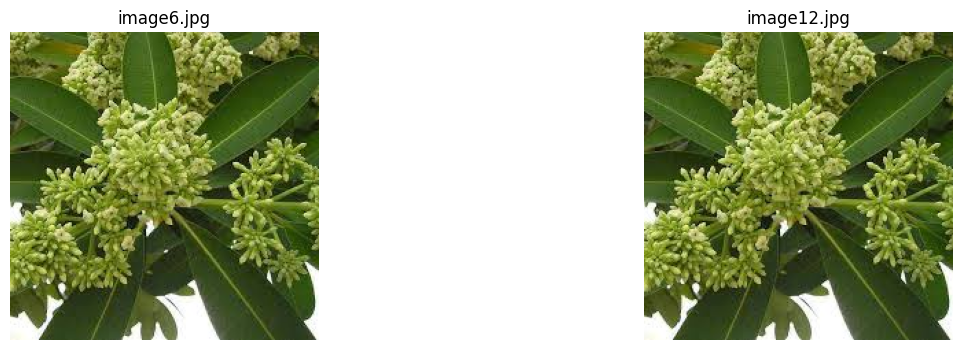

Duplicate set 2:


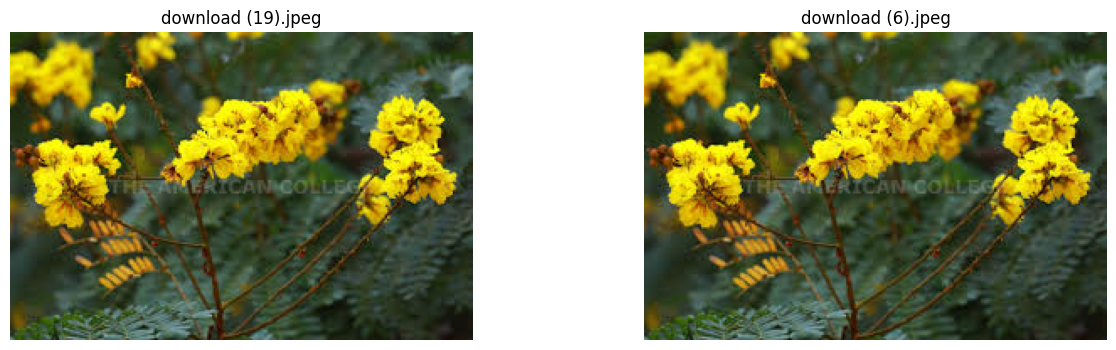

Duplicate set 3:


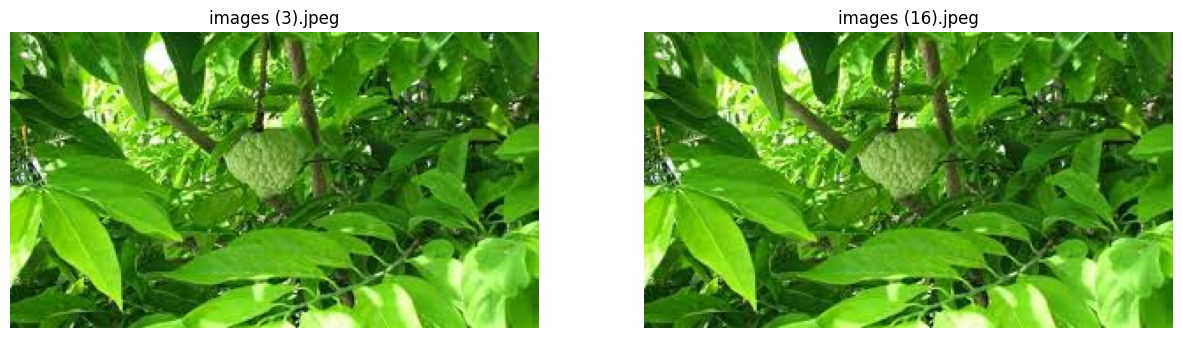

In [20]:
import matplotlib.pyplot as plt
from PIL import Image

def show_duplicate_sets(duplicates, sets_to_display=3):
    shown = 0
    for hash_val, dup_paths in duplicates.items():
        if shown >= sets_to_display:
            break
        print(f"Duplicate set {shown + 1}:")
        plt.figure(figsize=(15, 4))
        for i, img_path in enumerate(dup_paths):
            try:
                img = Image.open(img_path)
                plt.subplot(1, len(dup_paths), i+1)
                plt.imshow(img)
                plt.title(os.path.basename(img_path))
                plt.axis('off')
            except:
                continue
        plt.show()
        shown += 1

show_duplicate_sets(duplicates, sets_to_display=3)


In [21]:
import os

removed_count = 0

for dup_list in duplicates.values():
    # Keep the first, delete rest
    for img_path in dup_list[1:]:
        try:
            os.remove(img_path)
            removed_count += 1
        except Exception as e:
            print(f"Error deleting {img_path}: {e}")

print(f"✅ Removed {removed_count} duplicate images.")


✅ Removed 85 duplicate images.


In [23]:
# Re-check to confirm duplicates removed
hashes = defaultdict(list)

for class_dir in class_dirs:
    class_folder = os.path.join(repo_path, class_dir)
    if os.path.isdir(class_folder): # Ensure it's a directory
        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            if os.path.isfile(img_path): # Check if it's a file
                try:
                    with open(img_path, 'rb') as f:
                        file_hash = hashlib.md5(f.read()).hexdigest()
                        hashes[file_hash].append(img_path)
                except Exception as e:
                    print(f"Could not process file {img_path}: {e}")


duplicates = {h: files for h, files in hashes.items() if len(files) > 1}
print("🔁 Duplicates remaining:", len(duplicates))

🔁 Duplicates remaining: 0


In [24]:
from PIL import Image
import pandas as pd

# Gather image info
image_info = []

for class_dir in class_dirs:
    class_path = os.path.join(repo_path, class_dir)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                image_info.append({
                    'path': img_path,
                    'width': width,
                    'height': height,
                    'class': class_dir
                })
        except:
            continue

df_sizes = pd.DataFrame(image_info)

# Define thresholds
small_imgs = df_sizes[(df_sizes['width'] < 150) | (df_sizes['height'] < 150)]
large_imgs = df_sizes[(df_sizes['width'] > 1000) | (df_sizes['height'] > 2000)]

print(f"🔻 Very small images: {len(small_imgs)}")
print(f"🔺 Very large images: {len(large_imgs)}")


🔻 Very small images: 20
🔺 Very large images: 0


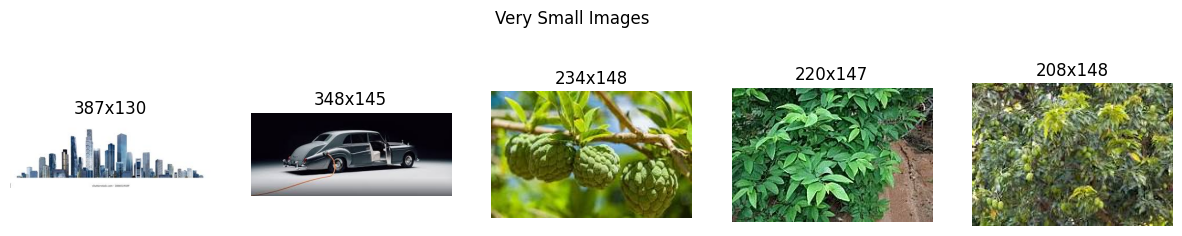

<Figure size 1500x300 with 0 Axes>

In [25]:
def show_images(df_subset, title, n=5):
    plt.figure(figsize=(15, 3))
    for i, (_, row) in enumerate(df_subset.head(n).iterrows()):
        img = Image.open(row['path'])
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"{row['width']}x{row['height']}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_images(small_imgs, "Very Small Images")
show_images(large_imgs, "Very Large Images")


In [26]:
import os

# Combine both sets
outliers = pd.concat([small_imgs, large_imgs])

# Remove them
removed_count = 0
for path in outliers['path']:
    try:
        os.remove(path)
        removed_count += 1
    except Exception as e:
        print(f"Failed to remove {path}: {e}")

print(f"🗑️ Removed {removed_count} outlier images (small + large).")


🗑️ Removed 20 outlier images (small + large).


In [27]:
# Recalculate sizes
image_info = []

for class_dir in class_dirs:
    class_path = os.path.join(repo_path, class_dir)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                image_info.append({
                    'path': img_path,
                    'width': width,
                    'height': height,
                    'class': class_dir
                })
        except:
            continue

df_sizes = pd.DataFrame(image_info)
print(df_sizes[['width', 'height']].describe())


             width       height
count  1359.000000  1359.000000
mean    249.172185   214.698308
std      46.162689    43.636690
min     150.000000   150.000000
25%     224.500000   183.000000
50%     259.000000   194.000000
75%     275.000000   238.000000
max     500.000000   500.000000


In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Augmentation and rescaling
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    repo_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    repo_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 1099 images belonging to 31 classes.
Found 260 images belonging to 31 classes.


In [29]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetB0(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), weights='imagenet')
base_model.trainable = False  # Freeze base model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │         3,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,217,538 (16.09 MB)

 Trainable params: 167,967 (656.12 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [30]:
EPOCHS = 10

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.0322 - loss: 3.4808 - val_accuracy: 0.0538 - val_loss: 3.4177
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.0392 - loss: 3.4244 - val_accuracy: 0.0308 - val_loss: 3.4156
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.0491 - loss: 3.4191 - val_accuracy: 0.0538 - val_loss: 3.4143
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.0545 - loss: 3.4172 - val_accuracy: 0.0538 - val_loss: 3.4121
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.0441 - loss: 3.4123 - val_accuracy: 0.0538 - val_loss: 3.4075
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.0475 - loss: 3.4158 - val_accuracy: 0.0423 - val_loss: 3.4073
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.0327 - loss: 3.4182 - val_accuracy: 0.0538 - val_loss: 3.4068
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.0555 - loss: 3.4161 - val_accuracy: 0.0538 - v

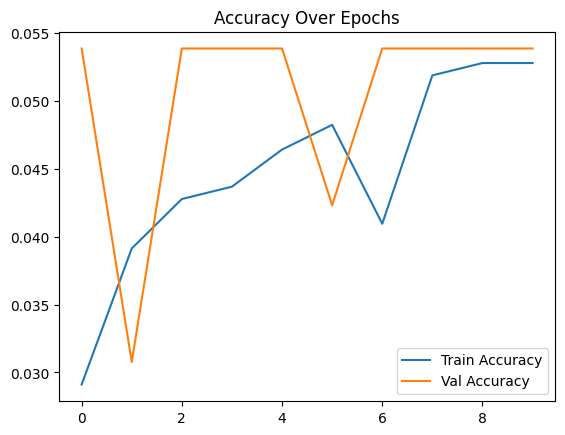

In [31]:
# Plot accuracy/loss curves
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy Over Epochs")
plt.show()

# Save model
model.save("tree_species_model.h5")


In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image properties
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Data generators
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    repo_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    repo_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Number of output classes
num_classes = train_generator.num_classes

# Build a basic CNN model
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_cnn.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train the model
EPOCHS = 10
history_cnn = model_cnn.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)

# Save the model
model_cnn.save('basic_cnn_tree_species.h5')
print("✅ Basic CNN model saved as 'basic_cnn_tree_species.h5'")


Found 1099 images belonging to 31 classes.
Found 260 images belonging to 31 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 168s 5s/step - accuracy: 0.0502 - loss: 3.8325 - val_accuracy: 0.0846 - val_loss: 3.3208
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 156s 4s/step - accuracy: 0.0445 - loss: 3.3402 - val_accuracy: 0.1154 - val_loss: 3.1723
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 155s 4s/step - accuracy: 0.0856 - loss: 3.2379 - val_accuracy: 0.1346 - val_loss: 3.0893
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 157s 4s/step - accuracy: 0.1162 - loss: 3.1608 - val_accuracy: 0.0923 - val_loss: 3.1562
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 166s 5s/step - accuracy: 0.1077 - loss: 3.1678 - val_accuracy: 0.0962 - val_loss: 3.0825
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 167s 5s/step - accuracy: 0.1614 - loss: 2.9986 - val_accuracy: 0.1654 - val_loss: 2.8870
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 158s 4s/step - accuracy: 0.2005 - loss: 2.8436 - val_accuracy: 0.2346 - val_loss: 2.8353
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 165s 5s/step - accuracy: 0.1935 - loss: 2.8107 - val_accuracy: 0.2385 - v

✅ Basic CNN model saved as 'basic_cnn_tree_species.h5'


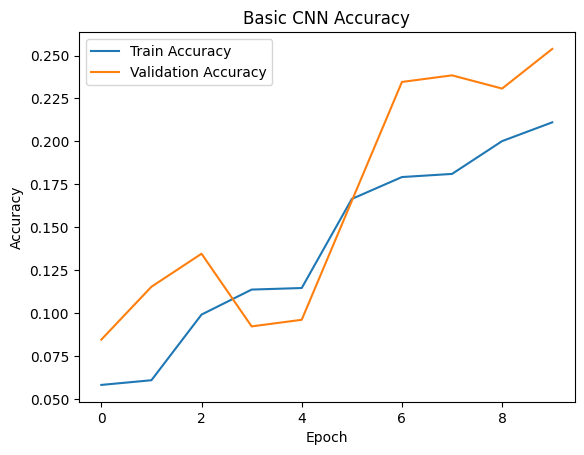

In [33]:
import matplotlib.pyplot as plt

plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title("Basic CNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(31, activation='softmax')  # For 31 classes
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_generator, validation_data=val_generator, epochs=25)

model.save("improved_cnn_model.h5")


Epoch 1/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 246s 7s/step - accuracy: 0.0809 - loss: 5.0905 - val_accuracy: 0.0269 - val_loss: 7.0620
Epoch 2/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 230s 7s/step - accuracy: 0.0763 - loss: 3.3432 - val_accuracy: 0.0269 - val_loss: 11.5997
Epoch 3/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 227s 6s/step - accuracy: 0.1015 - loss: 3.2642 - val_accuracy: 0.0385 - val_loss: 14.1617
Epoch 4/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 234s 7s/step - accuracy: 0.1079 - loss: 3.2425 - val_accuracy: 0.0346 - val_loss: 16.2861
Epoch 5/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 232s 7s/step - accuracy: 0.1337 - loss: 3.2232 - val_accuracy: 0.0346 - val_loss: 18.6885
Epoch 6/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 226s 6s/step - accuracy: 0.1133 - loss: 3.1523 - val_accuracy: 0.0346 - val_loss: 14.7281
Epoch 7/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 266s 7s/step - accuracy: 0.1438 - loss: 3.1790 - val_accuracy: 0.0308 - val_loss: 14.0185
Epoch 8/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 258s 6s/step - accuracy: 0.1328 - loss: 3.1431 - val_accuracy: 0.03